# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [17]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [19]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.365971
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Because of weights are initialized as uniform, all classes should have similar probability at start. Since the dataset has 10 classes the probability of each class should be 10% with initial weights which means 10 / 100 = 0.1. Since our loss function is $L_i = - \log (\frac{e^{sy_i}}{\sum_{j=1}^{n}{e^{s_j}}})$ the result inside of the log should be equal to 0.1 because of uniformity.. For this reason we assume that our loss close to be $- \log (0.1)$* 



In [20]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.671614 analytic: -2.671614, relative error: 2.399359e-08
numerical: -2.612628 analytic: -2.612628, relative error: 2.300347e-08
numerical: -1.914258 analytic: -1.914259, relative error: 4.477100e-08
numerical: -1.933152 analytic: -1.933152, relative error: 1.069127e-08
numerical: 0.256216 analytic: 0.256216, relative error: 1.788911e-07
numerical: 0.033395 analytic: 0.033395, relative error: 1.831351e-06
numerical: -0.467230 analytic: -0.467230, relative error: 1.878228e-08
numerical: -5.347996 analytic: -5.347996, relative error: 1.009578e-08
numerical: -0.052110 analytic: -0.052110, relative error: 7.534453e-08
numerical: -1.887022 analytic: -1.887022, relative error: 7.052309e-09
numerical: 2.609508 analytic: 2.609508, relative error: 8.916607e-09
numerical: -1.629870 analytic: -1.629870, relative error: 1.524172e-08
numerical: 3.430314 analytic: 3.430314, relative error: 3.069536e-09
numerical: -1.317663 analytic: -1.317663, relative error: 3.938231e-08
numerical: -0.

In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.365971e+00 computed in 0.162063s
vectorized loss: 2.365971e+00 computed in 0.005588s
Loss difference: 0.000000
Gradient difference: 0.000000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-7, 1e-7, 5e-8, 1e-8]
regularization_strengths = [1e4, 2.5e4, 5e4, 7.5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, verbose=False)
        # Prediction to calculate training accuracy
        y_train_pred = softmax.predict(X_train)
        # Traning accuracy
        train_accuracy = np.mean(y_train == y_train_pred)
        
        # Prediction to calculate validation accuracy
        y_val_pred = softmax.predict(X_val)
        # Validation accuracy
        val_accuracy = np.mean(y_val == y_val_pred)

        # Train and validation accuracies are stored in results dictionary. 
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_softmax = softmax
            best_val = val_accuracy


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.091163 val accuracy: 0.107000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.097531 val accuracy: 0.093000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.132959 val accuracy: 0.130000
lr 1.000000e-08 reg 7.500000e+04 train accuracy: 0.112755 val accuracy: 0.106000
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.122592 val accuracy: 0.129000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.134857 val accuracy: 0.122000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.137163 val accuracy: 0.139000
lr 5.000000e-08 reg 7.500000e+04 train accuracy: 0.126204 val accuracy: 0.154000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.147224 val accuracy: 0.172000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.146020 val accuracy: 0.165000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.192245 val accuracy: 0.194000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.183592 val accuracy: 0.168000
lr 5.000000e-07 reg 1.000000

In [23]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.310000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ Since the SVM loss function is $max(0, s_j - s_y + 1)$ if this $s_y > s_j + 1$ condition is satisfied for all data SVM loss will not change. If the training loss of recent model is zero it may still continue as zero with new dataset. For this reason, SVM loss may remain unchanged with new dataset. To explain it more clearly, assume that we have scores of [2, 11, 9, 8, 5] and assuming 11 is the correct class each loss value will be zero of this input. The reason is $11 > 2 + 1, 11 > 9 + 1, 11 > 8 + 1, 11 > 5 + 1$ all conditions are satisfied so each loss will be 0. To implement more visualization to show why these losses will be zero is $max(0, 2 - 11 + 1), max(0, 9 - 11 + 1), max(0, 8 - 11 + 1), max(0, 5 - 11 + 1)$ so 0 will be maximum value for each implementation.

However, because of the loss function of Softmax which is $L_i = - \log (\frac{e^{sy_i}}{\sum_{j=1}^{n}{e^{s_j}}})$, it is not possible to obtain same loss of different datasets. The reason is, Softmax will have probabilities for each class and this probability is different for each input. Even though, all losses close to 0.001 it is will not be the same because of floating numbers. Assuming same input [2, 11, 9, 8, 5] if we want to find the loss we should get exponential of each value and sum them and exponential of 11 which is correct class will be divided to sum. Finally -log() will be applied to calculate final loss. To visualize exponentials of each value is [7.38905610e+00, 5.98741417e+04, 8.10308393e+03, 2.98095799e+03, 1.48413159e+02] and result loss is 0.17203930312807225. Let's assume our input array was [2, 11, 9, 7, 5] for SVM loss it would not change anything but for Softmax loss our new loss is 0.14518467717594596. Thus, we can say that SVM may remain same with same loss but Softmax may not.



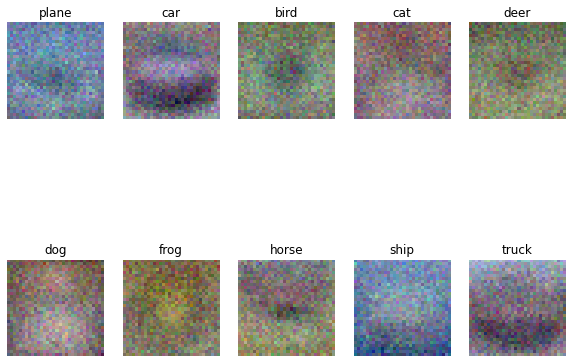

In [24]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])